In [12]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import opendatasets
opendatasets.download("https://www.kaggle.com/datasets/samaneheslamifar/facial-emotion-expressions")

Skipping, found downloaded files in "./facial-emotion-expressions" (use force=True to force download)


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf


# size of the image: 48*48 pixels
pic_size = 48
data_folder = '/content/facial-emotion-expressions/images/'
print(os.listdir(data_folder))
train_classes= os.listdir(data_folder + "train")
validation_classes = os.listdir(data_folder + "validation")
print('Classes in Training Set: ',train_classes)
print('Classes in Validation Set: ' ,validation_classes)



['images', 'validation', 'train']
Classes in Training Set:  ['sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear', 'angry']
Classes in Validation Set:  ['sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear', 'angry']


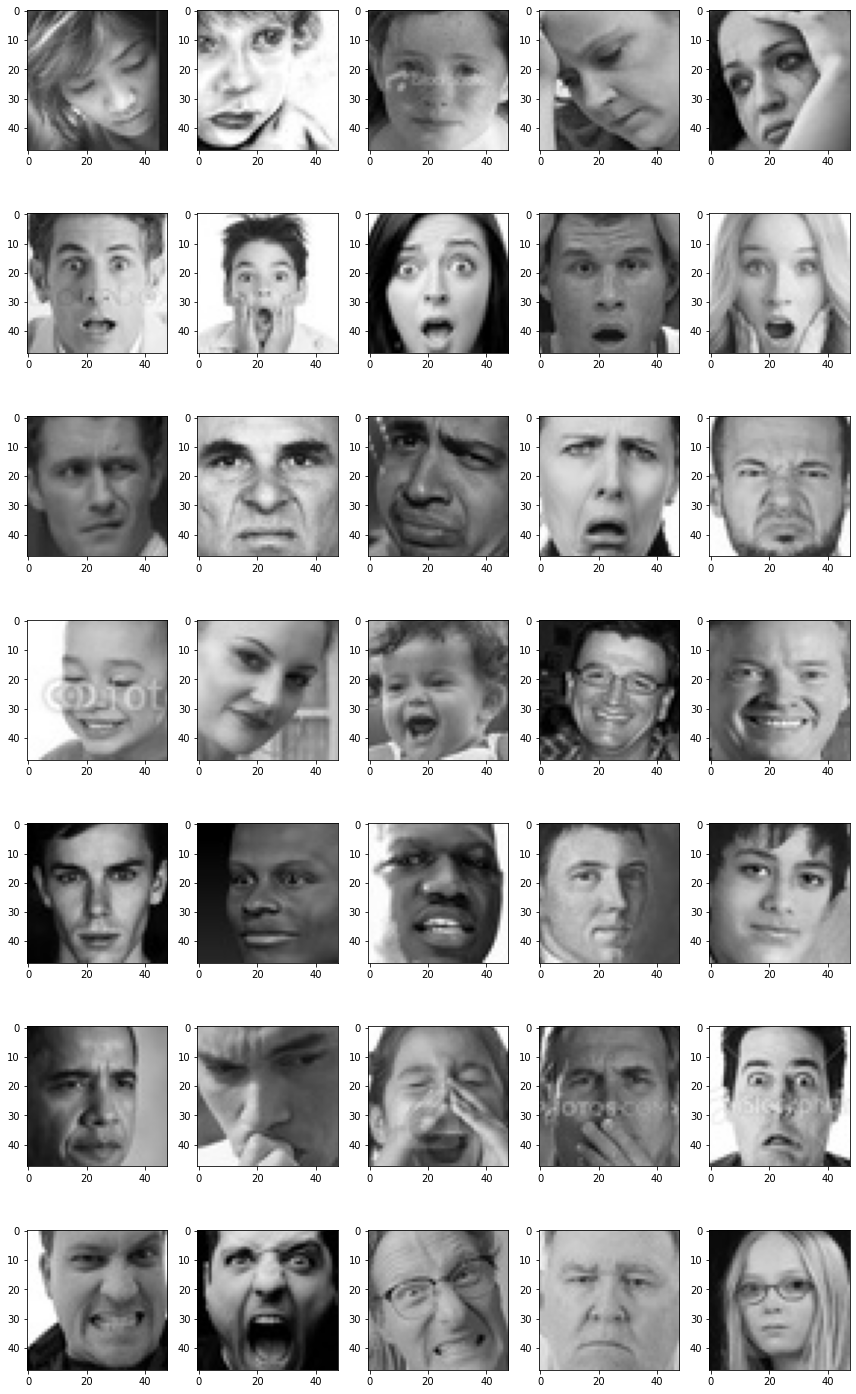

In [15]:
from tensorflow.keras.utils import load_img

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(data_folder + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(data_folder + "train/" + expression + "/" +os.listdir(data_folder + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [16]:
for expression in os.listdir(data_folder + "train"):
    print(str(len(os.listdir(data_folder + "train/" + expression))) + " " + expression + " images")

4938 sad images
3205 surprise images
436 disgust images
7164 happy images
4982 neutral images
4103 fear images
3993 angry images


In [23]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 32

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_ds = datagen_train.flow_from_directory(data_folder + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_ds = datagen_validation.flow_from_directory(data_folder + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [18]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

nb_classes = 7

model = Sequential()

#Convolution Layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Flattening
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Softmax
model.add(Dense(nb_classes, activation='softmax'))

#Optimization
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [1]:
model.summary()

NameError: ignored

In [22]:
from keras.callbacks import ModelCheckpoint

epochs = 40

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_ds,
          steps_per_epoch=train_ds.n//train_ds.batch_size,
          epochs=epochs,
          validation_data = validation_ds,
          validation_steps = validation_ds.n//validation_ds.batch_size,
          callbacks=callbacks_list,
          verbose=1)

model.summary()

Epoch 1/40
898/900 [============================>.] - ETA: 0s - loss: 1.6769 - accuracy: 0.3570
Epoch 1: val_accuracy improved from -inf to 0.40156, saving model to model_weights.h5
900/900 [==============================] - 25s 28ms/step - loss: 1.6763 - accuracy: 0.3574 - val_loss: 1.6159 - val_accuracy: 0.4016
Epoch 2/40
899/900 [============================>.] - ETA: 0s - loss: 1.5684 - accuracy: 0.3992
Epoch 2: val_accuracy improved from 0.40156 to 0.41420, saving model to model_weights.h5
900/900 [==============================] - 25s 28ms/step - loss: 1.5686 - accuracy: 0.3991 - val_loss: 1.5703 - val_accuracy: 0.4142
Epoch 3/40
900/900 [==============================] - ETA: 0s - loss: 1.4724 - accuracy: 0.4366
Epoch 3: val_accuracy improved from 0.41420 to 0.47983, saving model to model_weights.h5
900/900 [==============================] - 25s 28ms/step - loss: 1.4724 - accuracy: 0.4366 - val_loss: 1.3481 - val_accuracy: 0.4798
Epoch 4/40
899/900 [============================>

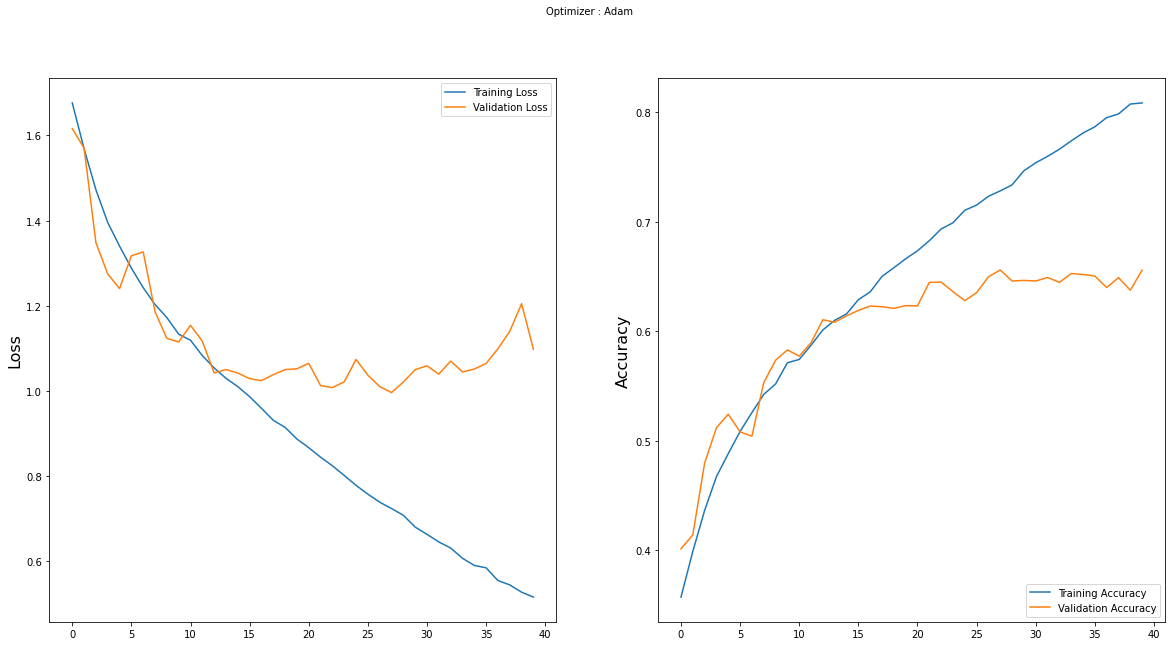

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()